In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../../')

from skyburst.plot import *
from skyburst import utils

# Backfill vs. Out-of-Order Scheduling

In [2]:
sim_df = utils.load_logs_as_dataframe('/home/gcpuser/logs/appendix/backfill.log')

In [17]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=2.25)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    ('zero', 1, 0, 0): 'No-Wait',
    ('linear_cost', 0.076, 0, 0): 'Compute-Wait',
    ('linear_cost', 0.076, 0, 1): 'Compute-Wait + OO',
    ('linear_cost', 0.076, 1, 0): 'Compute-Wait + Backfill',
    
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 1.1*(baseline_cost - cost)
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    # Nromalize by max vluae
    diff_df['cost_diff'] = diff_df['cost_diff']/diff_df['cost_diff'].max()
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    old_groupby_values = groupby_values
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if label == 'No-Wait':
                if ax_idx < 1:
                    continue
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2), loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/backfill.pdf', bbox_inches='tight')
    plt.show()  

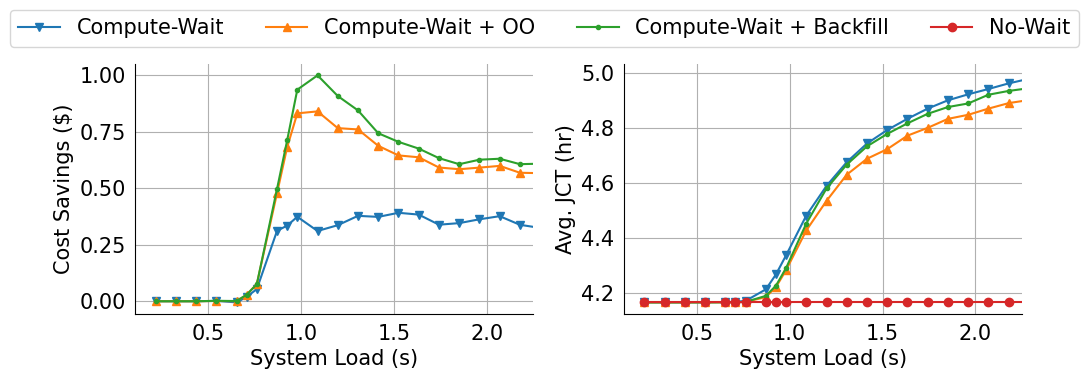

In [18]:
simulator_plotting_fn(sim_df, x_axis='arrival_rate',  \
                      y_axis=['cost_diff','avg_jct',], \
                      baseline_filter={'waiting_policy': 'zero','predict_wait': 0},
                      groupby_values=['waiting_policy', 'waiting_factor', 'backfill', 'loop'],
                      normalize_x_axis=True)

# Constant Wait Ablate OO

In [29]:
constant_df = sim_df = utils.load_logs_as_dataframe('/home/gcpuser/logs/appendix/constant_loop_ablate.log')

In [34]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(right=2.25)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'true_total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

# legend_dict = {
#     'constant': 'Constant-Wait',
#     'linear_runtime': 'Runtime',
#     'linear_cost': 'Cost',
#     'zero': 'No-Wait',
#     'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
# }

legend_dict = {
    ('constant', 1, 0): 'Constant Wait (C=1)',
    ('constant', 1, 1): 'Constant Wait (C=1)',
    ('constant', 4, 0): 'Constant Wait (C=4)',
    ('constant', 4, 1): 'Constant Wait (C=4)',
    ('zero', 0, 0): 'No-Wait',
    
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    df['true_total_cloud_cost'] = df['total_cloud_cost'] * 2.5
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['true_total_cloud_cost_y']
        cost = row['true_total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=30000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        cost_mult = 100 * (1 - (cost/baseline_cost))
#         if row['norm_system_utilization'] < 0.75 and cost_mult < 0 :
#             return 5
#         print(row['norm_system_utilization'], row['avg_jct_x'])
        return 100 * (1 - (cost/baseline_cost))
    
    def cost_difference(row):
        baseline_cost = row['true_total_cloud_cost_y']
        cost = row['true_total_cloud_cost_x']
        return baseline_cost - cost
    
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    # Normalize cost diff by absolute value of the max
    diff_df['cost_diff'] = diff_df['cost_diff'] / diff_df['cost_diff'].abs().max()
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        legend = None
        if label[0] == 'zero':
            color = 'tab:blue'
            marker = 'v'
        elif label[0] == 'constant':
            if label[1] == 1:
                color = 'tab:orange'
                marker = '^'
            elif label[1] == 4:
                color = 'tab:red'
                marker = 'o'
        
        if label[2]:
            linestyle='solid'
            alpha = 1
            linewidth=1.5
            if label[0] == 'zero':
                linewidth=1.5
                linestyle = 'solid'
        else:
            linestyle=(0, (1,1))
            alpha = 1
            linewidth=3
            if label[0] == 'zero':
                linewidth=1.5
                linestyle = 'solid'
        label = legend_dict[label]

        for ax_idx, ax in enumerate(axs):
            if label == 'No-Wait' and ax_idx<2:
                continue
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], color=color, linestyle=linestyle, marker=marker, linewidth=linewidth, ax = ax, label = label, legend=None, markersize=4)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    # fig.legend(lines, labels, ncol=len(labels), \
    #            bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    from matplotlib.lines import Line2D
    leg = fig.legend([lines[4], lines[1], lines[3]], \
               [labels[4], labels[1], labels[3]], ncol=3, \
               bbox_to_anchor=(0, 1.02, 1, 0.2),loc='upper center')
    fig.legend( [Line2D([0], [0], color='black', linestyle='solid', lw=1.5),
         Line2D([0], [0], color='black', linestyle=(0, (1, 1)), lw=3)], ['OO', 'No-OO'], ncol=2, bbox_to_anchor=(0, 0.88, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/constant_wait_loop.pdf', bbox_inches='tight')
    plt.show()  

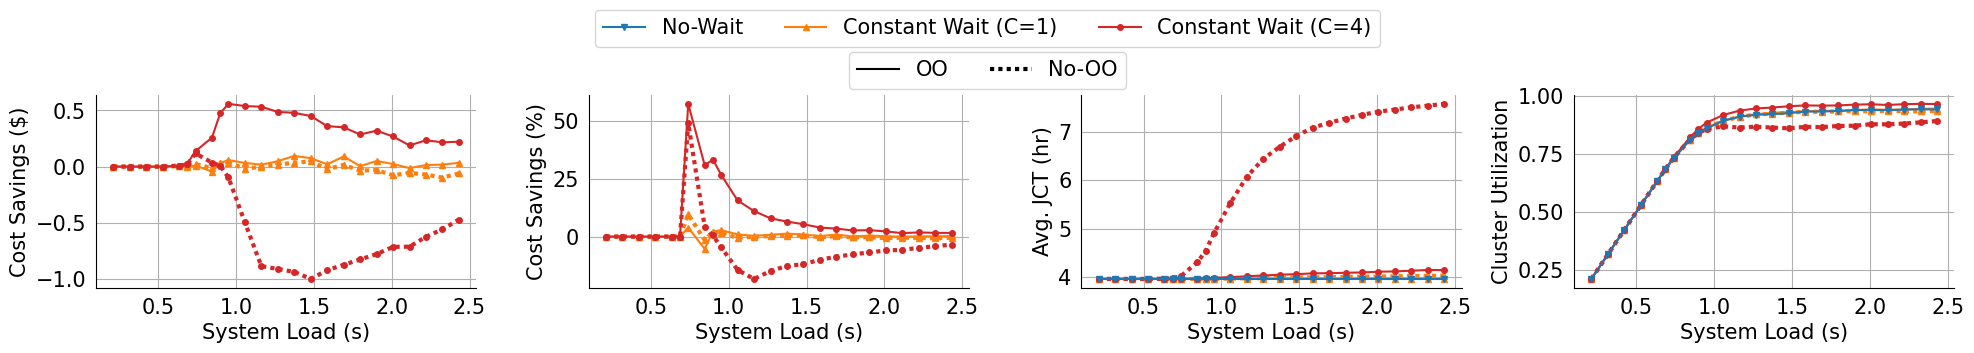

In [35]:
simulator_plotting_fn(constant_df, x_axis='arrival_rate',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero',},
                      groupby_values=['waiting_policy', 'waiting_factor', 'loop'],
                      normalize_x_axis=True)

# Time Estimator Errors

In [36]:
time_error_df = utils.load_logs_as_dataframe('/home/gcpuser/logs/appendix/time_estimator_error_gen.log')

In [37]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'linear_capacity_filter_cpu': 'Starburst (No Time)',
    'linear_cost_filter_cpu': 'Starburst',
    'zero': 'No-Wait',
    ('linear_runtime', 1000000): 'Compute',
    ('zero', 1000000): 'No-Wait',
    ('linear_runtime_filter_cpu', 10): 'Compute+No-CPU+Limit-Queue',
    ('linear_runtime_filter_cpu', 1000000): 'Compute+No-CPU',
    ('zero', 0): 'No-Wait',
    ('linear_cost_filter_cpu', 0): 'Starburst (0%)',
    ('linear_cost_filter_cpu', 10): '10%',
    ('linear_cost_filter_cpu', 25): '25%',
    ('linear_cost_filter_cpu', 50): '50%',
    ('linear_cost_filter_cpu', 100): '100%',
    
    
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
#     axs = [axs]
    df = df[df['waiting_policy']!='linear_capacity_filter_cpu']
    df = df[df['time_estimator_error']!=500]
    df = df[df['time_estimator_error']!=200]
    for k,v in df_filter.items():
        df = df[df[k]==v]
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
#             if label == 'No-Wait + Loop':
#                 continue
            if ax_idx < 2 and label=='No-Wait':
                continue
            #color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, \
               labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/time_estimator_short.pdf', bbox_inches='tight')
    plt.show()  

('linear_cost_filter_cpu', 0)
('linear_cost_filter_cpu', 10)
('linear_cost_filter_cpu', 25)
('linear_cost_filter_cpu', 50)
('linear_cost_filter_cpu', 100)
('zero', 0)


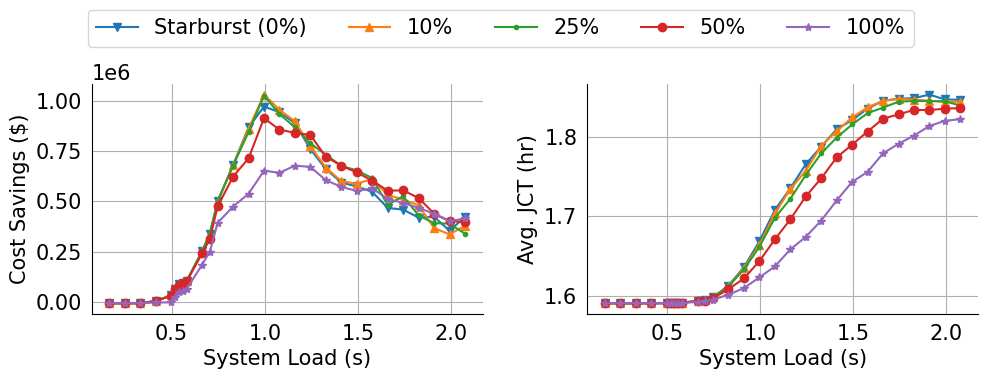

In [40]:

simulator_plotting_fn(time_error_df, x_axis='arrival_rate',  \
                      y_axis = ['cost_diff', 'avg_jct'],
                      #y_axis=['cost_mult','cost_diff','avg_jct', 'cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy','time_estimator_error'],
                      normalize_x_axis=True)

# Data Gravity

In [2]:
data_df = sim_df = utils.load_logs_as_dataframe('/home/gcpuser/logs/appendix/philly_data_gravity.log')

In [10]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=2.25)
    # Get current plot size
    fig_size = ax.figure.get_size_inches()
    # Increase vertical dimension by 1.1x
    ax.figure.set_size_inches(fig_size[0], fig_size[1] * 1.1)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'true_total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

# legend_dict = {
#     'constant': 'Constant-Wait',
#     'linear_runtime': 'Runtime',
#     'linear_cost': 'Cost',
#     'zero': 'No-Wait',
#     'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
# }

legend_dict = {
    ('constant', 1, -1): 'Constant-Wait',
    ('constant', 1, 0.25): 'Constant-Wait',
    ('zero', 1, -1): 'No-Wait',
    ('zero', 1, 0.25): 'No-Wait',
    ('linear_cost', 0.076, -1): 'Starburst',
    ('linear_cost', 0.076, 0.25): 'Starburst',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    df['true_total_cloud_cost'] = df['total_cloud_cost'] * 2.5
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['true_total_cloud_cost_y']
        cost = row['true_total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=30000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        cost_mult = 100 * (1 - (cost/baseline_cost))
#         if row['norm_system_utilization'] < 0.75 and cost_mult < 0 :
#             return 5
#         print(row['norm_system_utilization'], row['avg_jct_x'])
        return 100 * (1 - (cost/baseline_cost))
    
    def cost_difference(row):
        baseline_cost = row['true_total_cloud_cost_y']
        cost = row['true_total_cloud_cost_x']
        return baseline_cost - cost
    
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    # Normalize cost diff by absolute value of the max
    diff_df['cost_diff'] = diff_df['cost_diff'] / diff_df['cost_diff'].abs().max()
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        print(label)
        legend = None
        if label[0] == 'zero':
            color = 'tab:blue'
            marker = 'v'
        elif label[0] == 'constant':
            color = 'tab:orange'
            marker = '^'
        elif label[0] == 'linear_cost':
            color = 'tab:red'
            marker = 'o'
        
        if label[2] == -1:
            linestyle='solid'
            alpha = 1
            linewidth=1.5
        else:
            linestyle=(0, (1,1))
            alpha = 1
            linewidth=3
        cur_label = legend_dict[label]

        for ax_idx, ax in enumerate(axs):
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], color=color, linestyle=linestyle, marker=marker, linewidth=linewidth, ax = ax, label = cur_label, legend=None, markersize=4)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    # fig.legend(lines, labels, ncol=len(labels), \
    #            bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    print(labels)
    print(len(lines))
    from matplotlib.lines import Line2D
    leg = fig.legend([lines[4], lines[0], lines[2]], \
               [labels[4], labels[1], labels[3]], ncol=3, \
               bbox_to_anchor=(0, 1.00, 1, 0.2),loc='upper center')
    fig.legend( [Line2D([0], [0], color='black', linestyle='solid', lw=1.5),
         Line2D([0], [0], color='black', linestyle=(0, (1, 1)), lw=3)], ['No-DG', 'DG'], ncol=2, bbox_to_anchor=(0, 0.88, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/data_gravity.pdf', bbox_inches='tight')
    plt.show()  

('constant', 1.0, -1.0)
('constant', 1.0, 0.25)
('linear_cost', 0.076, -1.0)
('linear_cost', 0.076, 0.25)
('zero', 1.0, -1.0)
('zero', 1.0, 0.25)
['Constant-Wait', 'Constant-Wait', 'Starburst', 'Starburst', 'No-Wait', 'No-Wait']
6


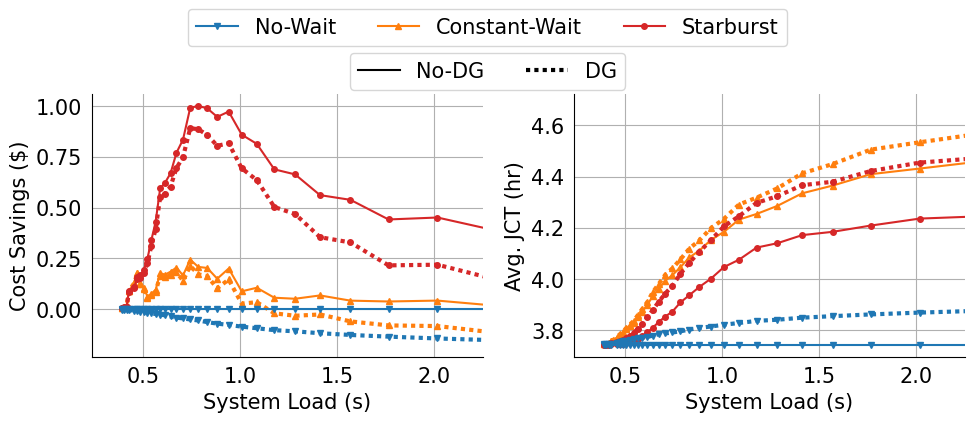

In [11]:
simulator_plotting_fn(data_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','avg_jct',], \
                      baseline_filter={'waiting_policy': 'zero', 'data_gravity': -1},
                      groupby_values=['waiting_policy', 'waiting_factor', 'data_gravity'],
                      normalize_x_axis=True)

# Job Offloading over Starburst

In [3]:
jct_df = utils.load_logs_as_dataframe('/home/gcpuser/logs/appendix/jct_offload.log')

In [42]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_xlim(right=2.8)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    ('linear_cost', 1000000): 'Compute-Wait',
    ('zero', 1000000): 'No-Wait',
    ('linear_cost_filter_cpu', 10): 'Compute-Wait\n+No-CPU\n+Limit-Queue',
    ('linear_cost_filter_cpu', 1000000): 'Compute-Wait\n+No-CPU',
    ('linear_runtime_filter_cpu', 10): 'Compute-Wait\n+No-CPU\n+Limit-Queue',
    ('linear_runtime_filter_cpu', 1000000): 'Compute-Wait\n+No-CPU',
    ('linear_runtime', 1000000): 'Compute-Wait',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if label == 'No-Wait + Loop' or label == 'No-Wait':
                continue
#             if ax_idx < 2 and label=='No-Wait':
#                 continue
            #color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    # axs[0].legend([lines[0], lines[2], lines[1], lines[3]], \
    #            [labels[0], labels[2], labels[1], labels[3]], prop={'size': 12}, loc='upper left')
    ncols = 2
    nlines  = 3
    print(lines)
    lines = [lines[0], lines[2], lines[1]]
    labels = [labels[0], labels[2], labels[1]]
    # lines.insert(nlines//ncols, plt.plot([],[],color=(0,0,0,0), label=" ")[0])
    # labels.insert(nlines//ncols, "  ")
    spacing = 0.5
    leg = fig.legend(lines, \
               labels, bbox_to_anchor=(0, 0.45, 1.37, 0.2), ncol=1,loc='right', fontsize=12.5, borderpad=spacing)
    leg._legend_box.align = "right"
    plt.tight_layout()
    plt.savefig('figures/evaluation/jct.pdf', bbox_inches='tight')
    plt.show()  

('linear_runtime', 1000000)
('linear_runtime_filter_cpu', 10)
('linear_runtime_filter_cpu', 1000000)
('zero', 1000000)
[<matplotlib.lines.Line2D object at 0x7fbfcefe3520>, <matplotlib.lines.Line2D object at 0x7fbfcef5de20>, <matplotlib.lines.Line2D object at 0x7fbfcef5daf0>]


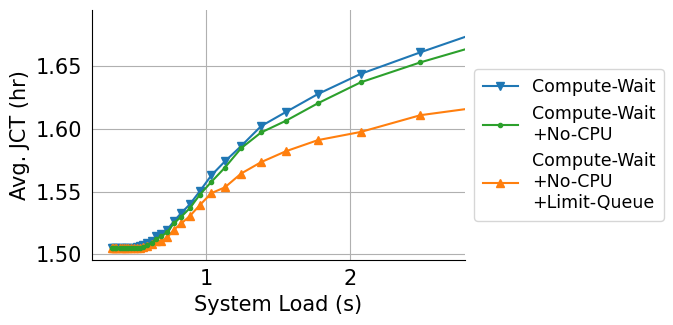

In [43]:

simulator_plotting_fn(jct_df, x_axis='cluster_size',  \
                      y_axis=['avg_jct'], \
                      baseline_filter={'waiting_policy': 'zero'},
                      groupby_values=['waiting_policy', 'max_queue_length'],
                      normalize_x_axis=True)